## Portfolio Optimization - SPDR Sector ETFs (2 year Adj Close Data)

In [1]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.models import Range1d, HoverTool
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

#### Get Data & Calculate Basic Stats

In [2]:
start_date = '2017-03-05'
end_date = '2019-03-05'
syms = ['XLE','XLF','XLU','XLI','XLK','XLV','XLY','XLP','XLB']

prices = data.DataReader(syms, 'yahoo', start_date, end_date)['Adj Close']
N = prices.shape[1]
display(prices.head())

returns = prices.pct_change()[1:]
display(returns.head())

Symbols,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2017-03-06,50.380669,67.775238,23.933243,63.677711,51.244270,51.907421,48.107944,73.214569,84.543297
2017-03-07,50.101414,67.174034,23.865637,63.494835,51.244270,51.841240,48.079876,72.700676,84.270340
2017-03-08,50.101414,65.426811,23.875292,63.273472,51.302525,51.727779,47.387543,72.991562,84.621300
2017-03-09,49.947346,65.858910,23.962215,62.984734,51.292820,51.812870,47.284630,73.389099,84.543297
2017-03-10,50.178452,65.764984,23.942904,63.369705,51.564674,52.049248,47.677574,73.670273,84.670036


Symbols,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2017-03-07,-0.005543,-0.008871,-0.002825,-0.002872,0.000000,-0.001275,-0.000583,-0.007019,-0.003229
2017-03-08,0.000000,-0.026010,0.000405,-0.003486,0.001137,-0.002189,-0.014400,0.004001,0.004165
2017-03-09,-0.003075,0.006604,0.003641,-0.004563,-0.000189,0.001645,-0.002172,0.005446,-0.000922
2017-03-10,0.004627,-0.001426,-0.000806,0.006112,0.005300,0.004562,0.008310,0.003831,0.001499
2017-03-13,0.002878,0.000143,0.002420,-0.000607,0.000941,0.000727,0.002944,-0.000790,0.002648


In [3]:
stats = pd.concat((returns.mean(),returns.std(),(returns+1).prod()-1),axis=1)
stats.columns = ['Mean_return', 'Volatility', 'Total_return']
stats

,Mean_return,Volatility,Total_return
Symbols,,,
XLB,0.000225,0.010101,0.091093
XLE,0.000027,0.011786,-0.021029
XLF,0.000252,0.010482,0.103904
XLI,0.000390,0.009835,0.186915
XLK,0.000718,0.011997,0.382789
XLP,0.000111,0.007460,0.042433
XLU,0.000376,0.008092,0.188161
XLV,0.000488,0.008992,0.251663
XLY,0.000590,0.009705,0.313292


In [4]:
extremes = pd.concat((stats.idxmin(),stats.min(),stats.idxmax(),stats.max()),axis=1)
extremes.columns = ['Minimizer','Minimum','Maximizer','Maximum']
extremes

,Minimizer,Minimum,Maximizer,Maximum
Mean_return,XLE,0.000027,XLK,0.000718
Volatility,XLP,0.007460,XLK,0.011997
Total_return,XLE,-0.021029,XLK,0.382789


#### Plot Normalized Cumulative Returns

In [5]:
growth = (returns+1.0).cumprod() 
tx = growth.index 
syms = growth.columns #symbols
esyms = pd.concat((extremes['Minimizer'],extremes['Maximizer'])) #extreme symbols

fig = figure(x_axis_type='datetime', y_axis_type='linear', y_axis_label='Cumulative Return',
             tools="pan,box_zoom,reset",plot_width=900, plot_height=600)

# Plot the extreme stocks
for (symb,c) in zip(esyms,{'green','red','blue','purple'}):
    fig.line(tx, growth[symb], legend=symb, color=c, line_width=2)
    fig.text([tx[-1]], [growth[symb][-1]], [symb], text_font_size='10px', text_baseline='middle', alpha=1.0)
    
# Equal allocation
eq_growth = growth.mean(axis=1)
fig.line(tx, eq_growth, color='maroon', legend='equal allocation', line_width=2)

# All the other stocks, and the text labels
for symb in syms:
    if symb not in esyms:
        fig.line(tx, growth[symb], color='maroon', alpha=0.25, name=symb)
        fig.text([tx[-1]], [growth[symb][-1]], [symb], text_font_size='10px', text_baseline='middle', alpha=0.25)

# Expand the y-axis
fig.y_range = Range1d(growth.values.min()/1.05,1.05*growth.values.max())
fig.legend.location='bottom_left'
show(fig)

#### Mean-Variance Scatter Plot

In [6]:
fig = figure(title='Mean-Variance Plot', tools="pan,box_zoom,reset",plot_width=700, plot_height=400)
fig.left[0].formatter.use_scientific = False
fig.circle(stats['Volatility'], stats['Mean_return'], size=5, color='maroon')
fig.text(stats['Volatility'], stats['Mean_return'], syms, text_font_size='10px', x_offset=3, y_offset=-2)
fig.xaxis.axis_label='Volatility (standard deviation)'
fig.yaxis.axis_label='Mean Daily Return'
show(fig)

### Optimize Weight Allocations Using Gurobi

$$\begin{array}{lll}
\text{minimize}   & x^T \Sigma x \\
\text{subject to} & \sum_i x_i = 1 & \text{fixed budget} \\
                  & r^T x = \gamma & \text{fixed return} \\
                  & x \geq 0
\end{array}$$

$x\in\mathbb{R}^N$ is a vector representing the fraction of the budget allocated to each asset. The paramters of the model are the mean returns $r$, a *covariance matrix* $\Sigma$, and the target return $\gamma$. The optimal risk-return tradeoff is determined by sweeping $\gamma$ between the worst and best returns seen above, and computing the portfolio that achieves the target return but with as little risk as possible.

In [7]:
Sigma = returns.cov()
Sigma

Symbols,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Symbols,,,,,,,,,
XLB,0.000102,0.000080,0.000075,0.000084,0.000087,0.000038,0.000010,0.000062,0.000073
XLE,0.000080,0.000139,0.000071,0.000075,0.000076,0.000032,0.000008,0.000057,0.000068
XLF,0.000075,0.000071,0.000110,0.000079,0.000083,0.000035,0.000002,0.000062,0.000071
XLI,0.000084,0.000075,0.000079,0.000097,0.000090,0.000040,0.000013,0.000066,0.000076
XLK,0.000087,0.000076,0.000083,0.000090,0.000144,0.000041,0.000014,0.000082,0.000099
XLP,0.000038,0.000032,0.000035,0.000040,0.000041,0.000056,0.000030,0.000041,0.000038
XLU,0.000010,0.000008,0.000002,0.000013,0.000014,0.000030,0.000065,0.000020,0.000011
XLV,0.000062,0.000057,0.000062,0.000066,0.000082,0.000041,0.000020,0.000081,0.000064
XLY,0.000073,0.000068,0.000071,0.000076,0.000099,0.000038,0.000011,0.000064,0.000094


In [8]:
# Import the Gurobi python module
from gurobipy import *

# Instantiate the model
m = Model("portfolio")

# Create one variable for each asset
portvars = [m.addVar(name=symb,lb=0.0) for symb in syms]
portvars = pd.Series(portvars, index=syms)
portfolio = pd.DataFrame({'Variables':portvars})

# Commit the changes to the model
m.update()

portfolio

Academic license - for non-commercial use only


,Variables
Symbols,
XLB,<gurobi.Var XLB>
XLE,<gurobi.Var XLE>
XLF,<gurobi.Var XLF>
XLI,<gurobi.Var XLI>
XLK,<gurobi.Var XLK>
XLP,<gurobi.Var XLP>
XLU,<gurobi.Var XLU>
XLV,<gurobi.Var XLV>
XLY,<gurobi.Var XLY>


#### Calculate portfolio return & risk

In [9]:
# The total budget
p_total = portvars.sum()

# The mean return for the whole portfolio
p_return = stats['Mean_return'].dot(portvars)

# The (squared) volatility of the portfolio
p_risk = Sigma.dot(portvars).dot(portvars) #first line of LP formulation

In [10]:
p_total

<gurobi.LinExpr: XLB + XLE + XLF + XLI + XLK + XLP + XLU + XLV + XLY>

In [11]:
p_return

<gurobi.LinExpr: 0.00022465340564875458 XLB + 2.7122013629363072e-05 XLE + 0.0002519757050215596 XLF + 0.00038989823987543566 XLI + 0.0007178808445970365 XLK + 0.0001106424871688211 XLP + 0.00037627253813230627 XLU + 0.000487707072005415 XLV + 0.0005900809270551753 XLY>

In [12]:
p_risk

<gurobi.QuadExpr: 0.0 + [ 0.00010203412234287192 XLB ^ 2 + 7.969493735245652e-05 XLE * XLB + 7.509984584249656e-05 XLF * XLB + 8.42721697353346e-05 XLI * XLB + 8.66162394166535e-05 XLK * XLB + 3.8096906607490404e-05 XLP * XLB + 1.0021335751199686e-05 XLU * XLB + 6.15967816231019e-05 XLV * XLB + 7.343638575917526e-05 XLY * XLB + 7.969493735245652e-05 XLB * XLE + 0.00013889995028208322 XLE ^ 2 + 7.096116648884983e-05 XLF * XLE + 7.460376616064062e-05 XLI * XLE + 7.647466158829104e-05 XLK * XLE + 3.2135370178993486e-05 XLP * XLE + 7.948108680246474e-06 XLU * XLE + 5.747473956912288e-05 XLV * XLE + 6.817698311028997e-05 XLY * XLE + 7.509984584249656e-05 XLB * XLF + 7.096116648884983e-05 XLE * XLF + 0.00010986376447114481 XLF ^ 2 + 7.911582320112207e-05 XLI * XLF + 8.28690121725639e-05 XLK * XLF + 3.50988009457829e-05 XLP * XLF + 2.3701169886598113e-06 XLU * XLF + 6.191562459060961e-05 XLV * XLF + 7.109852269290956e-05 XLY * XLF + 8.42721697353346e-05 XLB * XLI + 7.460376616064062e-05 XLE *

#### Add objective to minimize risk; Add fixed budget constraint

In [13]:
# Set the objective: minimize risk
m.setObjective(p_risk, GRB.MINIMIZE)

# Fix the budget
m.addConstr(p_total, GRB.EQUAL, 1)

# Select a simplex algorithm (to ensure a vertex solution)
m.setParam('Method', 1)

Changed value of parameter Method to 1
   Prev: -1  Min: -1  Max: 5  Default: -1


#### Solve minimum risk model (no target return specified yet)

In [14]:
m.optimize()

portfolio['Minimum risk'] = portvars.apply(lambda x:x.getAttr('x'))
portfolio

Optimize a model with 1 rows, 9 columns and 9 nonzeros
Model has 45 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 4e-04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 9 columns, 9 nonzeros
Presolved model has 45 quadratic objective terms

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       8    3.8045026e-05   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.01 seconds
Optimal objective  3.804502599e-05


,Variables,Minimum risk
Symbols,,
XLB,<gurobi.Var XLB (value 0.016992525171768545)>,0.016993
XLE,<gurobi.Var XLE (value 0.06444679427624088)>,0.064447
XLF,<gurobi.Var XLF (value 0.1525880775584346)>,0.152588
XLI,<gurobi.Var XLI (value 0.0)>,0.000000
XLK,<gurobi.Var XLK (value 0.0)>,0.000000
XLP,<gurobi.Var XLP (value 0.24680602143341732)>,0.246806
XLU,<gurobi.Var XLU (value 0.4385785242246754)>,0.438579
XLV,<gurobi.Var XLV (value 0.0)>,0.000000
XLY,<gurobi.Var XLY (value 0.08058805733546331)>,0.080588


#### 50% Max return portfolio (find the weights that result in a return that is 50% of the max possible - 100% allocation in top performer)

In [15]:
# Add the return target
ret50 = 0.5 * extremes.loc['Mean_return','Maximum']
fixreturn = m.addConstr(p_return, GRB.EQUAL, ret50)

m.optimize()

portfolio['50% Max'] = portvars.apply(lambda x:x.getAttr('x'))
portfolio['Maximum'] = [1.0 if x == 'XLU' else 0.0 for x in syms]
portfolio

Optimize a model with 2 rows, 9 columns and 18 nonzeros
Model has 45 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 4e-04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-04, 1e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8045026e-05   0.000000e+00   0.000000e+00      0s
       4    3.8791037e-05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  3.879103733e-05


,Variables,Minimum risk,50% Max,Maximum
Symbols,,,,
XLB,<gurobi.Var XLB (value 0.0)>,0.016993,0.000000,0.0
XLE,<gurobi.Var XLE (value 0.020234015473259148)>,0.064447,0.020234,0.0
XLF,<gurobi.Var XLF (value 0.13152335096907236)>,0.152588,0.131523,0.0
XLI,<gurobi.Var XLI (value 0.0)>,0.000000,0.000000,0.0
XLK,<gurobi.Var XLK (value 0.0)>,0.000000,0.000000,0.0
XLP,<gurobi.Var XLP (value 0.1408217202904382)>,0.246806,0.140822,0.0
XLU,<gurobi.Var XLU (value 0.4789198346441817)>,0.438579,0.478920,1.0
XLV,<gurobi.Var XLV (value 0.05243945790981197)>,0.000000,0.052439,0.0
XLY,<gurobi.Var XLY (value 0.17606162071323658)>,0.080588,0.176062,0.0


#### Plot Returns of Different Portfolios

In [16]:
fig = figure(x_axis_type='datetime',y_axis_type='log',tools="pan,box_zoom,reset",plot_width=900, plot_height=600)

pgrowth = returns.dot(portfolio.loc[:,'Minimum risk':'Maximum'])
pgrowth = (pgrowth + 1).cumprod()

for (t,c) in zip(['Minimum risk','50% Max','Maximum'],['red','green','blue']):
    fig.line(pgrowth.index, pgrowth[t], legend=t, color=c)

# fig.y_range = Range1d(1.0,1.1*pgrowth.max().max())
fig.legend.location="top_left"
show(fig)

#### Plot weight allocations for different portfolios

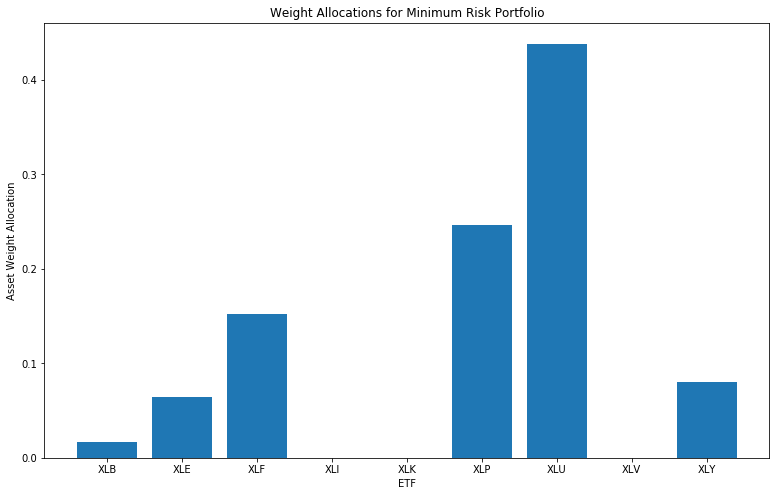

In [21]:
plt.rcParams["figure.figsize"] = (13,8)

plt.bar(x=syms, height=portfolio['Minimum risk'])
plt.xlabel('ETF')
plt.ylabel('Asset Weight Allocation')
plt.title('Weight Allocations for Minimum Risk Portfolio');

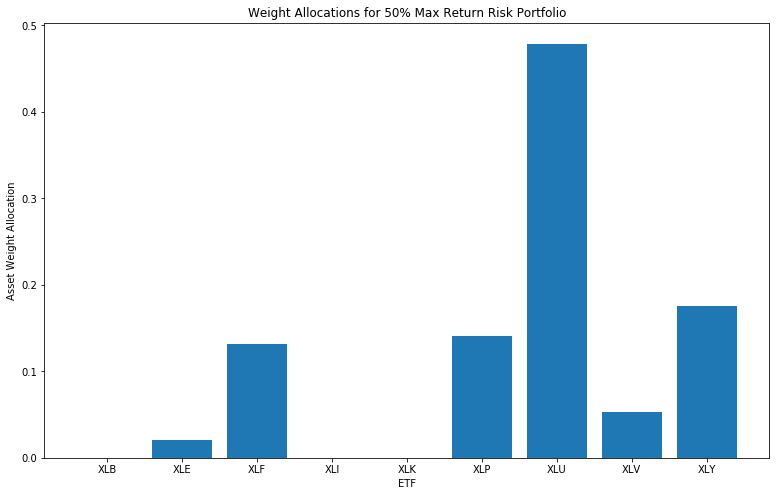

In [22]:
plt.bar(x=syms, height=portfolio['50% Max'])
plt.xlabel('ETF')
plt.ylabel('Asset Weight Allocation')
plt.title('Weight Allocations for 50% Max Return Risk Portfolio');

### The efficient frontier

In [18]:
from math import sqrt
# Turn off Gurobi's output
m.setParam('OutputFlag',False)

minret = extremes.loc['Mean_return','Minimum']
maxret = extremes.loc['Mean_return','Maximum']
riskret = extremes.loc['Volatility','Minimizer']
riskret = stats.loc[riskret,'Mean_return']
returns = np.unique(np.hstack((np.linspace(minret,maxret,100),riskret)))

# Iterate through all returns
risks = returns.copy()
for k in range(len(returns)):
    fixreturn.rhs = returns[k]
    m.optimize()
    risks[k] = sqrt(p_risk.getValue())

In [19]:
fig = figure(title='Efficient Frontier', tools="pan,box_zoom,reset",plot_width=900, plot_height=600)
fig.left[0].formatter.use_scientific = False

# Individual stocks
fig.circle(stats['Volatility'], stats['Mean_return'], size=5, color='maroon')
fig.text(stats['Volatility'], stats['Mean_return'], syms, text_font_size='10px', x_offset=3, y_offset=-2)

# Divide the efficient frontier into two sections: those with
# a return less than the minimum risk portfolio, those that are greater.
tpos_n = returns >= riskret
tneg_n = returns <= riskret
fig.line(risks[tneg_n], returns[tneg_n], color='red')
fig.line(risks[tpos_n], returns[tpos_n], color='blue')

fig.xaxis.axis_label='Volatility (standard deviation)'
fig.yaxis.axis_label='Mean return'
fig.legend.orientation='bottom_left'
show(fig)